**Note - Some part of the notebook have been taken from public kaggle kernels and edited as per the requirement**

**Importing Packages**

In [1]:
# Input data files are available in the "../input/" directory.

%matplotlib inline
import numpy as np
import pandas as pd
import cv2
import os
import glob
import h5py
import shutil
import itertools


import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mimg
from os import listdir, makedirs, getcwd, remove
from os.path import isfile, join, abspath, exists, isdir, expanduser

from PIL import Image
from pathlib import Path
from skimage.io import imread
from skimage.transform import resize
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix

from keras.models import Sequential, Model
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing.image import ImageDataGenerator,load_img, img_to_array
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Input, Flatten, SeparableConv2D, MaxPool2D, GlobalAveragePooling2D
from keras.layers import GlobalMaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers.merge import Concatenate
from keras.models import Model
from keras.optimizers import Adam, SGD, RMSprop
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from keras.utils import to_categorical
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import img_to_array
from keras.applications.vgg16 import preprocess_input
from keras.applications.vgg16 import decode_predictions
from keras.applications.vgg16 import VGG16


color = sns.color_palette()

print(os.listdir("../input/"))

Using TensorFlow backend.


['data', 'chest-xray-pneumonia']


**Reading Data**

In [ ]:
# data has been divided into three folders - train, val, and test. Each of these three folders further has two folders -
# - normal and pneumonia which consists of chest-xray images.

# Path to data directory
data_dir = '../input/chest-xray-pneumonia/data/data'

# Path to train directory
train_dir = data_dir + '/' + 'train' 

# Path to validation directory
val_dir = data_dir + '/' + 'val'

# Path to test directory
test_dir = data_dir + '/' + 'test'

**Preparing Sample Train Data**

In [5]:
# Get the path to the normal and pneumonia sub-directories
normal_cases_dir = train_dir + '/' +  'normal'
pneumonia_cases_dir = train_dir + '/' +  'pneumonia'

# Get the list of all the images
normal_cases = glob.glob(normal_cases_dir + '/' + '*')
pneumonia_cases = glob.glob(pneumonia_cases_dir + '/' + '*')

# An empty list. We will insert the data into this list in (img_path, label) format
train_data = []

# Go through all the normal cases. The label for these cases will be 0
for img in normal_cases:
    train_data.append((img,0))

# Go through all the pneumonia cases. The label for these cases will be 1
for img in pneumonia_cases:
    train_data.append((img, 1))

# Get a pandas dataframe from the data we have in our list 
train_data = pd.DataFrame(train_data, columns=['image', 'label'],index=None)

# Shuffle the data 
train_data = train_data.sample(frac=1.).reset_index(drop=True)

# How the dataframe looks like?
train_data.head()

image  label
0  ../input/chest-xray-pneumonia/data/data/train/...      1
1  ../input/chest-xray-pneumonia/data/data/train/...      1
2  ../input/chest-xray-pneumonia/data/data/train/...      0
3  ../input/chest-xray-pneumonia/data/data/train/...      1
4  ../input/chest-xray-pneumonia/data/data/train/...      1

**Sample of each class**

1    3890
0    1416
Name: label, dtype: int64


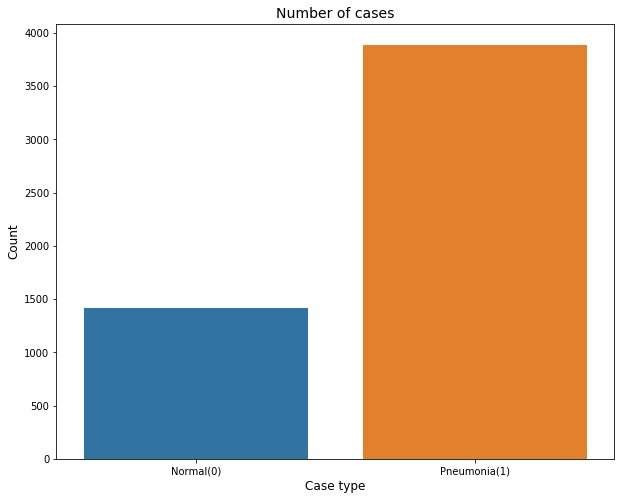

In [6]:
# Get the counts for each class
cases_count = train_data['label'].value_counts()
print(cases_count)

# Plot the results 
plt.figure(figsize=(10,8))
sns.barplot(x=cases_count.index, y= cases_count.values)
plt.title('Number of cases', fontsize=14)
plt.xlabel('Case type', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(range(len(cases_count.index)), ['Normal(0)', 'Pneumonia(1)'])
plt.show()

**Compare normal vs pneuomonia**

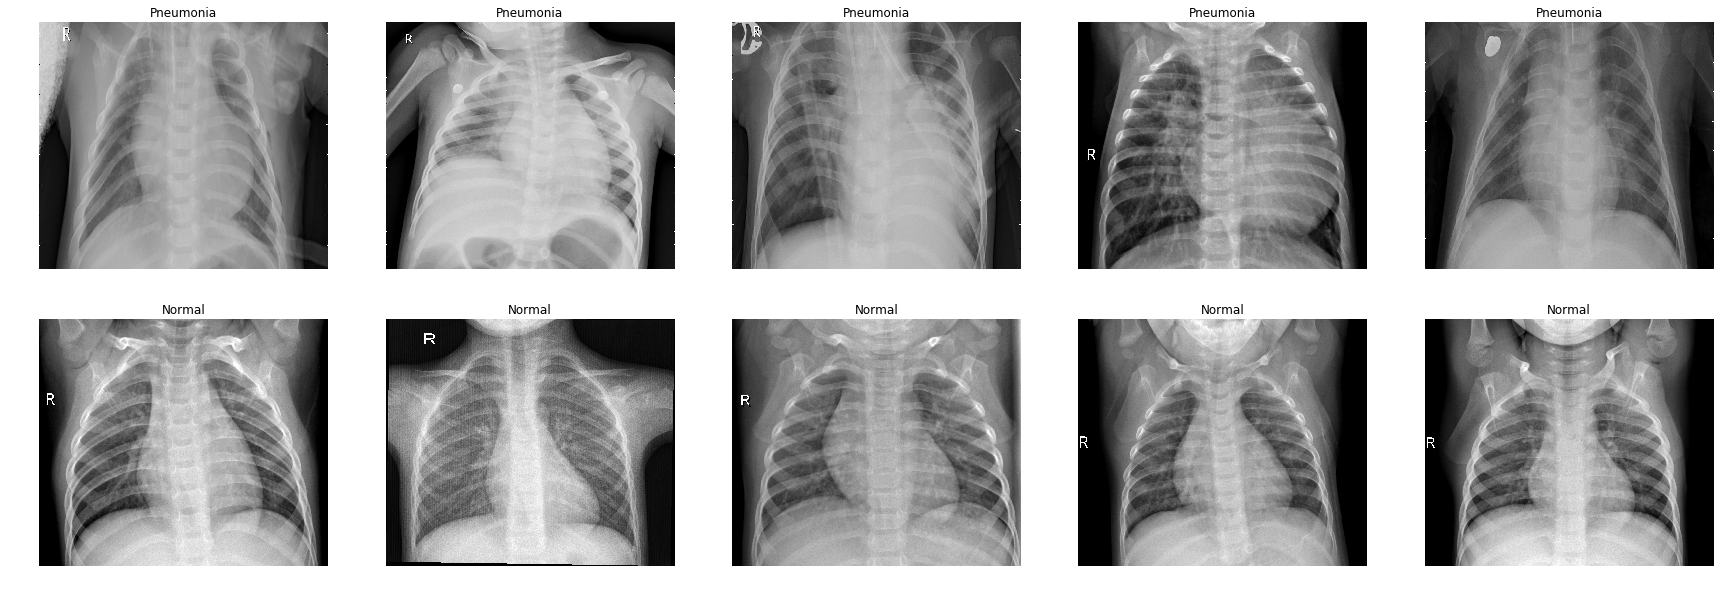

In [8]:
# Get few samples for both the classes
pneumonia_samples = (train_data[train_data['label']==1]['image'].iloc[:5]).tolist()
normal_samples = (train_data[train_data['label']==0]['image'].iloc[:5]).tolist()

# Concat the data in a single list and del the above two list
samples = pneumonia_samples + normal_samples
del pneumonia_samples, normal_samples

# Plot the data 
f, ax = plt.subplots(2,5, figsize=(30,10))
for i in range(10):
    img = imread(samples[i])
    ax[i//5, i%5].imshow(img, cmap='gray')
    if i<5:
        ax[i//5, i%5].set_title("Pneumonia")
    else:
        ax[i//5, i%5].set_title("Normal")
    ax[i//5, i%5].axis('off')
    ax[i//5, i%5].set_aspect('auto')
plt.show()

**Function to prepare data for modelling**

In [ ]:
def data_preparation(normal_cases, pneumonia_cases):
    
    # List that are going to contain images data and the corresponding labels
    data_list = []
    label_list = []


    # Some images are in grayscale while majority of them contains 3 channels. So, if the image is grayscale, 
    # we will convert into a image with 3 channels.
    # We will normalize the pixel values and resizing all the images to 224x224

    # Normal cases
    for img in normal_cases:
        img = cv2.imread(str(img))
        img = cv2.resize(img, (224,224))
        if img.shape[2] ==1:
            img = np.dstack([img, img, img])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = img.astype(np.float32)/255.
        label = to_categorical(0, num_classes=2)
        data_list.append(img)
        label_list.append(label)
                      
    # Pneumonia cases        
    for img in pneumonia_cases:
        img = cv2.imread(str(img))
        img = cv2.resize(img, (224,224))
        if img.shape[2] ==1:
            img = np.dstack([img, img, img])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = img.astype(np.float32)/255.
        label = to_categorical(1, num_classes=2)
        data_list.append(img)
        label_list.append(label)
        
    return data_list, label_list 

**Preparing Train Data**

In [11]:
# Get the path to the normal and pneumonia sub-directories
normal_cases_dir = train_dir + '//' + 'normal//*'
pneumonia_cases_dir = train_dir + '//' + 'pneumonia//*'

# Get the list of all the images
normal_cases = glob.glob(normal_cases_dir)
pneumonia_cases = glob.glob(pneumonia_cases_dir)

'''# List that are going to contain validation images data and the corresponding labels
train_data = []
train_label = []


# Some images are in grayscale while majority of them contains 3 channels. So, if the image is grayscale, we will convert into a image with 3 channels.
# We will normalize the pixel values and resizing all the images to 224x224

# Normal cases
for img in normal_cases:
    img = cv2.imread(str(img))
    img = cv2.resize(img, (224,224))
    if img.shape[2] ==1:
        img = np.dstack([img, img, img])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)/255.
    label = to_categorical(0, num_classes=2)
    train_data.append(img)
    train_label.append(label)
                      
# Pneumonia cases        
for img in pneumonia_cases:
    img = cv2.imread(str(img))
    img = cv2.resize(img, (224,224))
    if img.shape[2] ==1:
        img = np.dstack([img, img, img])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)/255.
    label = to_categorical(1, num_classes=2)
    train_data.append(img)
    train_label.append(label)'''
    
train_data, train_label =  data_preparation(normal_cases, pneumonia_cases)

# Convert the list into numpy arrays
train_data = np.array(train_data)
train_label = np.array(train_label)

print("Total number of training examples: ", train_data.shape)
print("Total number of labels:", train_label.shape)

Total number of training examples:  (5306, 224, 224, 3)
Total number of labels: (5306, 2)


**Preparing Validation Data**

In [14]:
# Get the path to the normal and pneumonia sub-directories
normal_cases_dir = val_dir + '//' + 'normal//*'
pneumonia_cases_dir = val_dir + '//' + 'pneumonia//*'

# Get the list of all the images
normal_cases = glob.glob(normal_cases_dir)
pneumonia_cases = glob.glob(pneumonia_cases_dir)

'''# List that are going to contain validation images data and the corresponding labels
val_data = []
val_label = []


# Some images are in grayscale while majority of them contains 3 channels. So, if the image is grayscale, we will convert into a image with 3 channels.
# We will normalize the pixel values and resizing all the images to 224x224

# Normal cases
for img in normal_cases:
    img = cv2.imread(str(img))
    img = cv2.resize(img, (224,224))
    if img.shape[2] ==1:
        img = np.dstack([img, img, img])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)/255.
    label = to_categorical(0, num_classes=2)
    val_data.append(img)
    val_label.append(label)
                      
# Pneumonia cases        
for img in pneumonia_cases:
    img = cv2.imread(str(img))
    img = cv2.resize(img, (224,224))
    if img.shape[2] ==1:
        img = np.dstack([img, img, img])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)/255.
    label = to_categorical(1, num_classes=2)
    val_data.append(img)
    val_label.append(label)'''
    
val_data, val_label = data_preparation(normal_cases, pneumonia_cases)

# Convert the list into numpy arrays
val_data = np.array(val_data)
val_label = np.array(val_label)

print("Total number of validation examples: ", val_data.shape)
print("Total number of labels:", val_label.shape)

Total number of validation examples:  (55, 224, 224, 3)
Total number of labels: (55, 2)


**Preparing Test Data**

In [16]:
# Get the path to the normal and pneumonia sub-directories
normal_cases_dir = test_dir + '//' + 'normal//*'
pneumonia_cases_dir = test_dir + '//' + 'pneumonia//*'

# Get the list of all the images
normal_cases = glob.glob(normal_cases_dir)
pneumonia_cases = glob.glob(pneumonia_cases_dir)

'''# List that are going to contain validation images data and the corresponding labels
test_data = []
test_label = []


# Some images are in grayscale while majority of them contains 3 channels. So, if the image is grayscale, we will convert into a image with 3 channels.
# We will normalize the pixel values and resizing all the images to 224x224

# Normal cases
for img in normal_cases:
    img = cv2.imread(str(img))
    img = cv2.resize(img, (224,224))
    if img.shape[2] ==1:
        img = np.dstack([img, img, img])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)/255.
    label = to_categorical(0, num_classes=2)
    test_data.append(img)
    test_label.append(label)
                      
# Pneumonia cases        
for img in pneumonia_cases:
    img = cv2.imread(str(img))
    img = cv2.resize(img, (224,224))
    if img.shape[2] ==1:
        img = np.dstack([img, img, img])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)/255.
    label = to_categorical(1, num_classes=2)
    test_data.append(img)
    test_label.append(label)'''

test_data, test_label =  data_preparation(normal_cases, pneumonia_cases)

# Convert the list into numpy arrays
test_data = np.array(test_data)
test_label = np.array(test_label)

print("Total number of test examples: ", test_data.shape)
print("Total number of labels:", test_label.shape)

Total number of test examples:  (651, 224, 224, 3)
Total number of labels: (651, 2)


**Data Generator to Augment Dataset**

In [19]:
# This generator will enrich our existing small dataset and provide variation in our data which will help to build robust model.

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=True,  # apply ZCA whitening
        rotation_range=12, # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False,)  # randomly flip images

**Defining Callbacks**

In [20]:
# Callback to prevent overfitting
es = EarlyStopping(patience=5)

# Reduce learning rate on plateau i.e. when there is no/minimal change in evaluation metrics
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.000001)

**VGG 16 Transfer Learning**

In [21]:
from keras.models import Model

def vgg16_model(img_rows, img_cols, channel=1, num_classes=None):

    model = VGG16(weights='imagenet', include_top=False,input_shape = (224,224,3))

    x=model.output

    x=GlobalAveragePooling2D()(x)
    x=Dense(512,activation='relu')(x)
    preds=Dense(num_classes,activation='softmax')(x)
    
    model=Model(inputs=model.input,outputs=preds)

    # To set the first 10 layers to non-trainable (weights will not be updated)
    for layer in model.layers[0:10]:
        layer.trainable = False

    # Defining optimizers
    adm = Adam(lr=0.0001)
    sgd = SGD(lr=1e-4, decay=1e-6, momentum=0.9, nesterov=True)
    
    model.compile(optimizer=adm, loss='categorical_crossentropy', metrics=['accuracy'])

    return model

In [22]:
img_rows, img_cols = 224, 224 # Resolution of inputs
channel = 3
num_classes = 2

# Load our model
model = vgg16_model(img_rows, img_cols, channel, num_classes)

Instructions for updating:
Colocations handled automatically by placer.
58892288/58889256 [==============================] - 3s 0us/step


In [23]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

**Model Training**

In [24]:
#Using Data Gen
datagen.fit(train_data)

# Training the model - I have used class_weight parameter because we have imbalanced data-set.
history_vgg = model.fit_generator(datagen.flow(train_data, train_label, batch_size=64),epochs = 10, 
                                   validation_data = (val_data,val_label),verbose = 1,
                                   steps_per_epoch=train_data.shape[0]//64
                                   , callbacks=[learning_rate_reduction,es],class_weight={0:1.0, 1:0.5})

Instructions for updating:
Use tf.cast instead.
Epoch 1/10
82/82 [==============================] - 63s 773ms/step - loss: 0.2066 - acc: 0.8655 - val_loss: 0.8055 - val_acc: 0.7636
Epoch 2/10
82/82 [==============================] - 60s 730ms/step - loss: 0.1067 - acc: 0.9383 - val_loss: 0.6053 - val_acc: 0.8182
Epoch 3/10
82/82 [==============================] - 60s 729ms/step - loss: 0.0735 - acc: 0.9588 - val_loss: 0.5655 - val_acc: 0.7818
Epoch 4/10
82/82 [==============================] - 58s 706ms/step - loss: 0.0578 - acc: 0.9672 - val_loss: 0.8838 - val_acc: 0.8000
Epoch 5/10
82/82 [==============================] - 59s 721ms/step - loss: 0.0584 - acc: 0.9649 - val_loss: 0.6490 - val_acc: 0.7818

Epoch 00005: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
Epoch 6/10
82/82 [==============================] - 59s 719ms/step - loss: 0.0421 - acc: 0.9775 - val_loss: 0.5133 - val_acc: 0.8182
Epoch 7/10
82/82 [==============================] - 59s 726ms/step - loss

**Loss and Accuracy Graph over epochs**

dict_keys(['val_loss', 'val_acc', 'loss', 'acc', 'lr'])


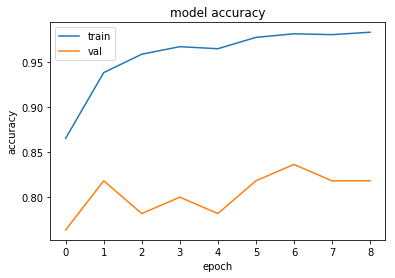

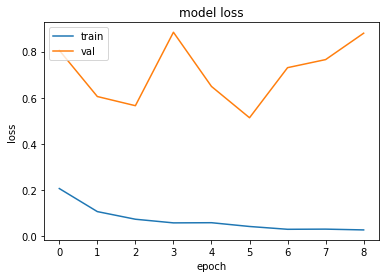

In [28]:
# list all data in history
print(history_vgg.history.keys())

# summarize history for accuracy
plt.plot(history_vgg.history['acc'])
plt.plot(history_vgg.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history_vgg.history['loss'])
plt.plot(history_vgg.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

** We can see from our metrics graphs that we can do a lot of work to further optimize the performance of our model. We can add more data, fine-tune the parameters and more**

**Confusion matrix**

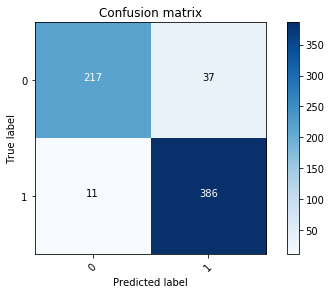

In [29]:
#Note, this code is taken straight from the SKLEARN website, an nice way of viewing confusion matrix.

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
Y_pred = model.predict(test_data)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred, axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(test_label, axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(2))

**Save model**

In [30]:
'''# serialize model to JSON
model_json = model.to_json()
with open("file_name.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("file_name.h5")
print("Saved model to disk")'''

Saved model to disk


**Reading sample test image**

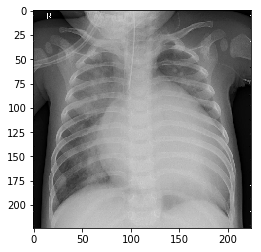

(1, 224, 224, 3)


In [31]:
from keras.preprocessing import image

img_path = '../input/chest-xray-pneumonia/data/data/train/normal/file_name.jpeg'
img = image.load_img(img_path, target_size=(224, 224))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
img_tensor /= 255.
plt.imshow(img_tensor[0])
plt.show()
print(img_tensor.shape)

**Predicting the Class**

In [32]:
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
images = np.vstack([x])
classes = model.predict(images, batch_size=64)
classes = classes.argmax(axis=-1)
print("Predicted class is:",classes)

Predicted class is: [0]


**Visualizing Activations of Intermediate layers**

In [33]:
from keras import models

# Extracts the outputs of the top 12 layers
layer_outputs = [layer.output for layer in model.layers[1:15]]

# Creates a model that will return these outputs, given the model input
activation_model = Model(inputs=model.input, outputs=layer_outputs)

# Returns a list of five Numpy arrays: one array per layer activation
activations = activation_model.predict(img_tensor)

**Displaying activations at each layer.
The first layer is retaining the full shape, although there are some filters that are not yet activated and are left blank. At this stage, the activations retains almost all of the information in the initial picture. As we go deeper into the layers, the activations become abstract and less visually interpretable. They begin to encode higher-level concepts such as single borders, corners and angles. Higher representations carry less information about the visual contents of the image, and more information related to the class of the image.**

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in true_divide


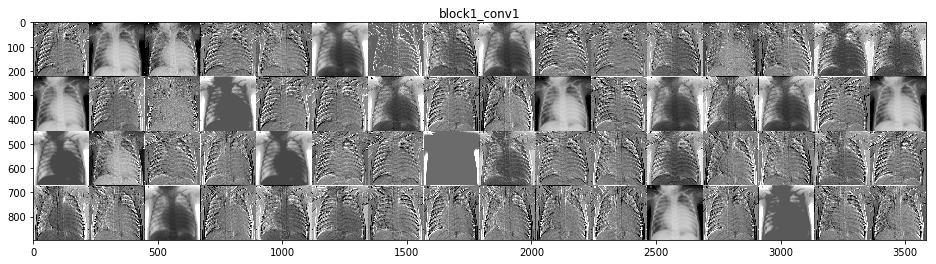

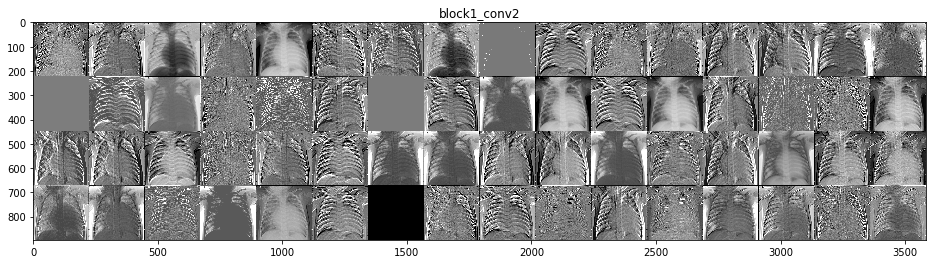

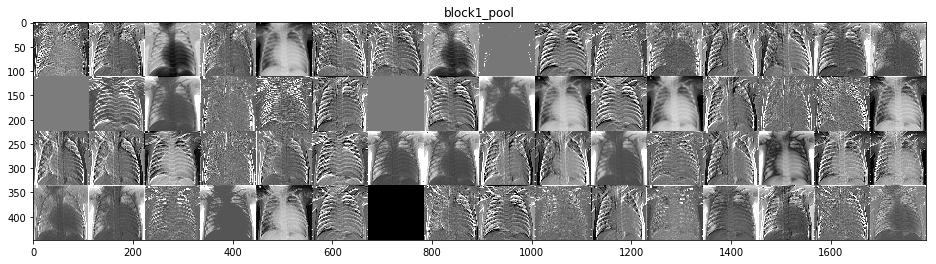

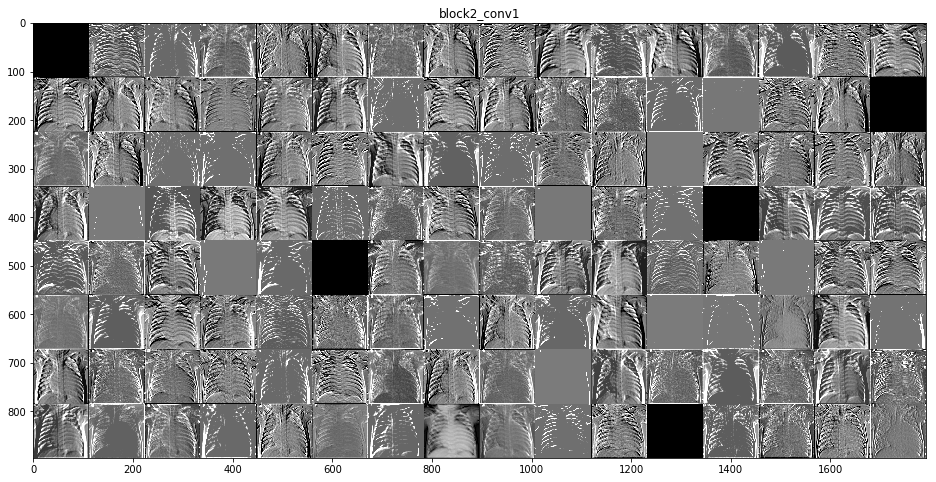

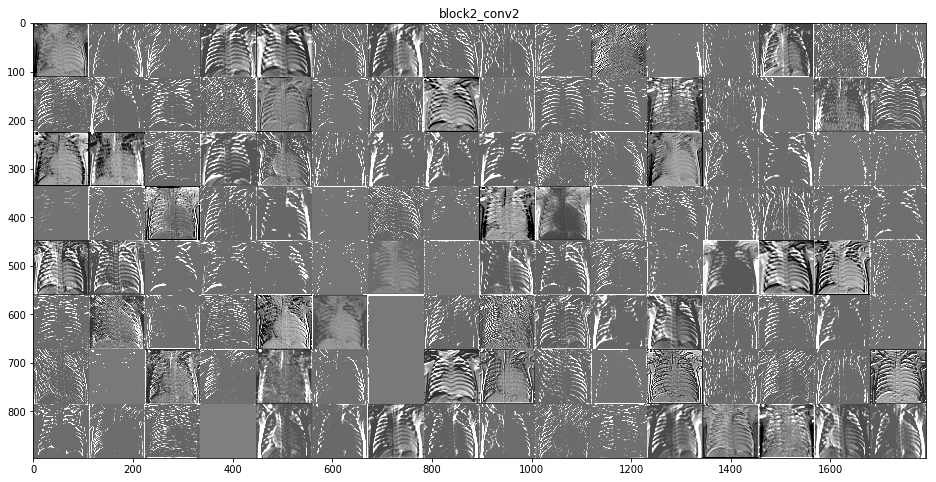

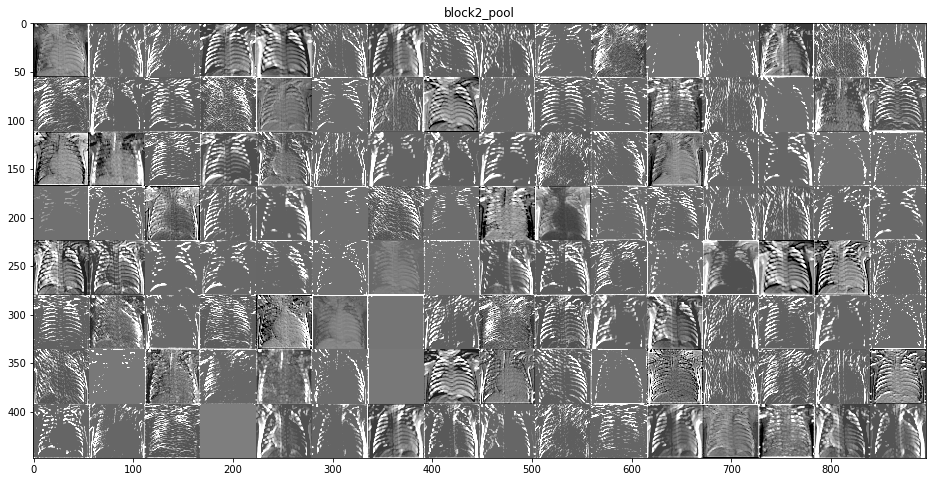

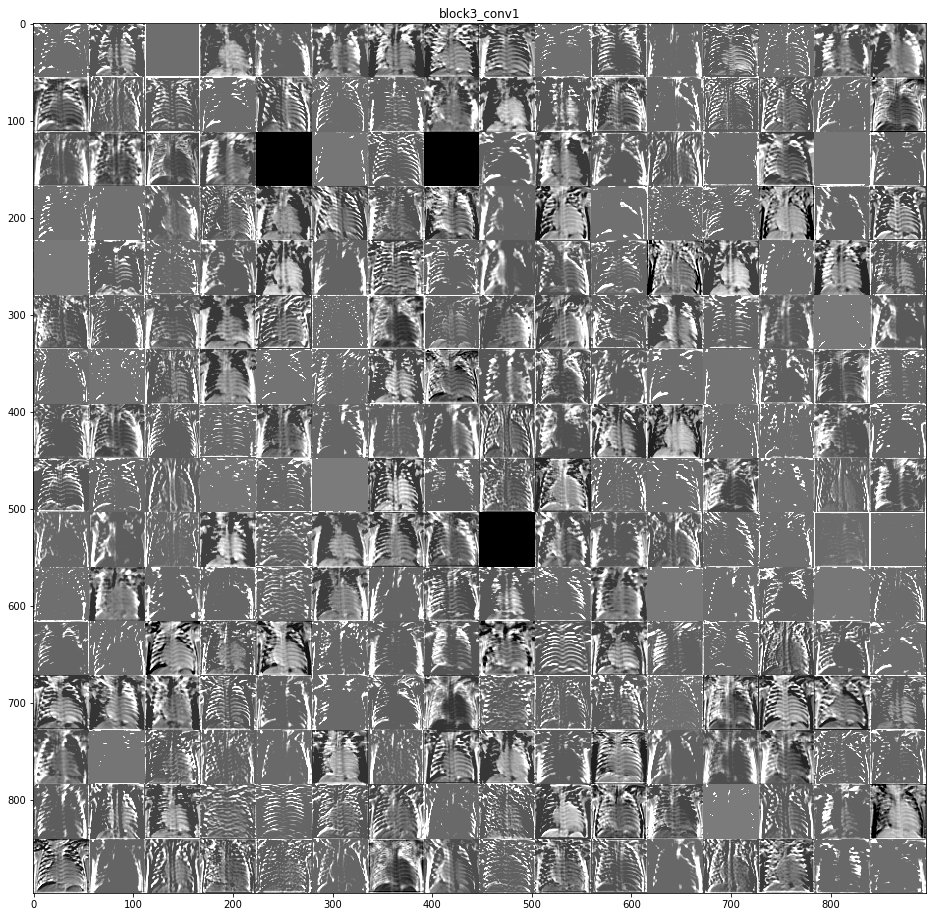

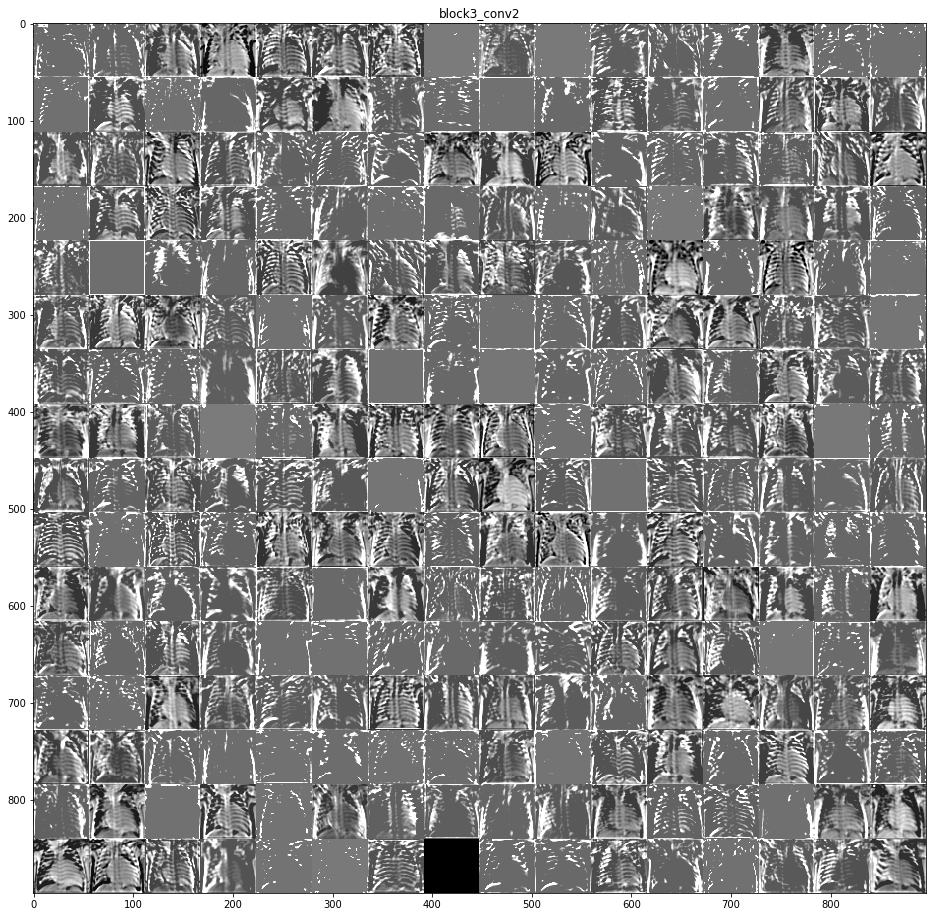

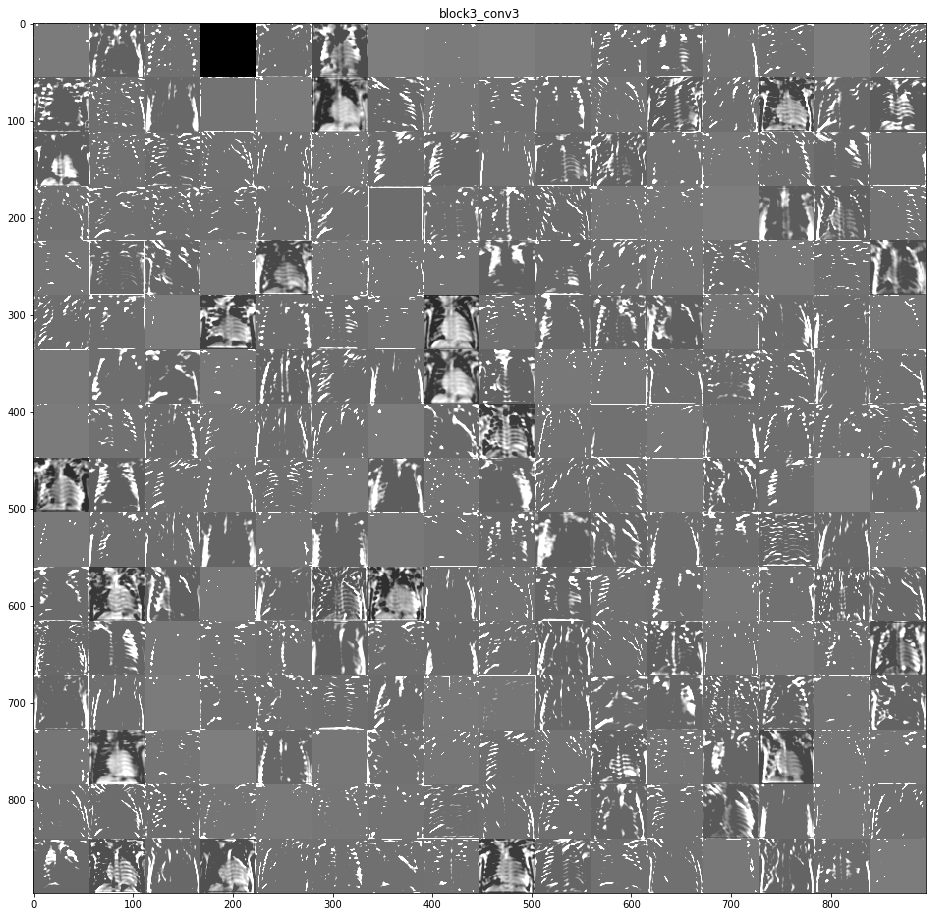

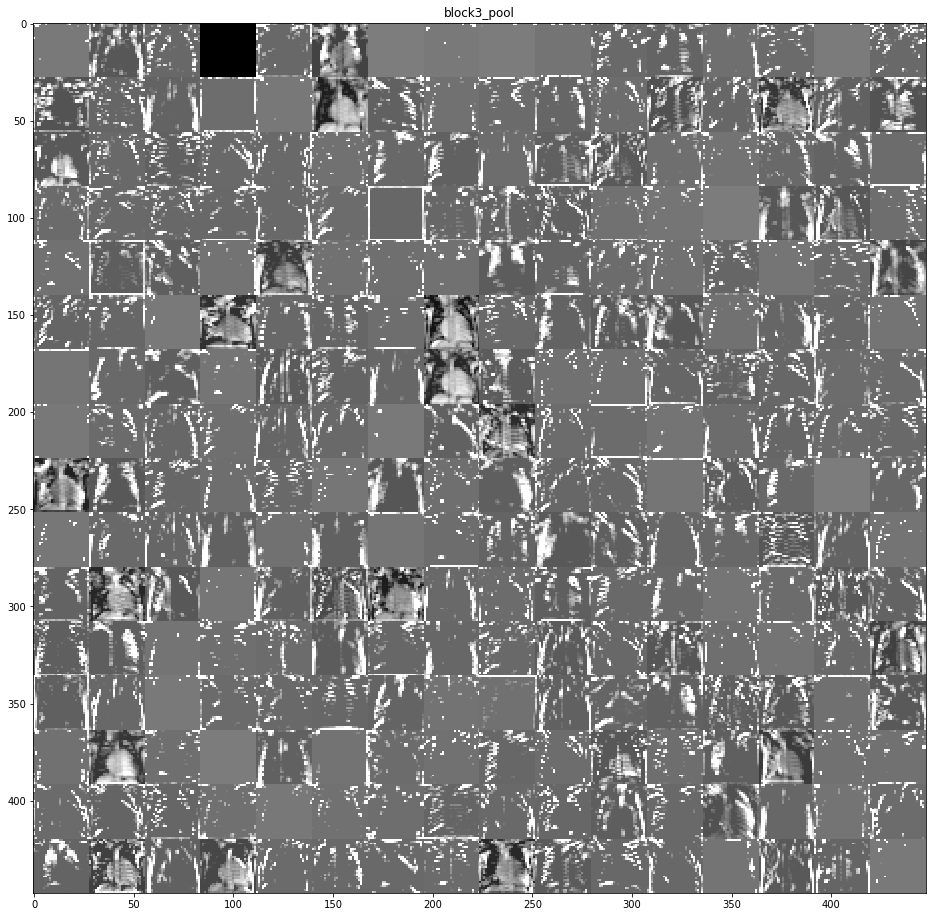

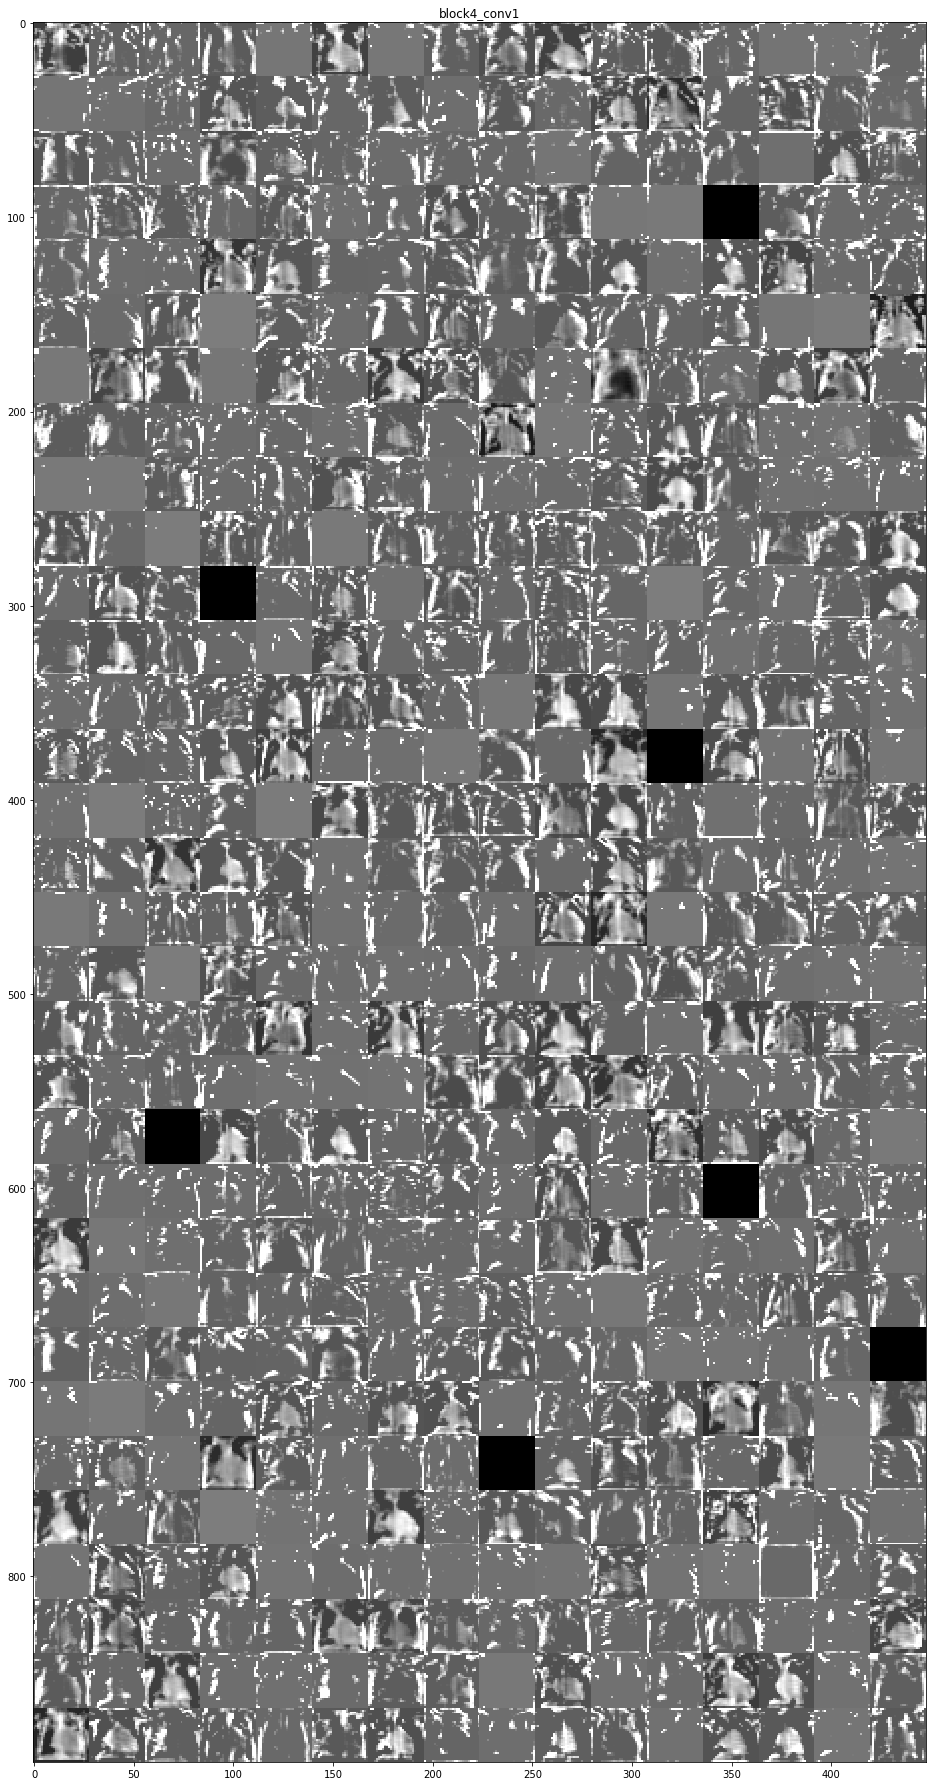

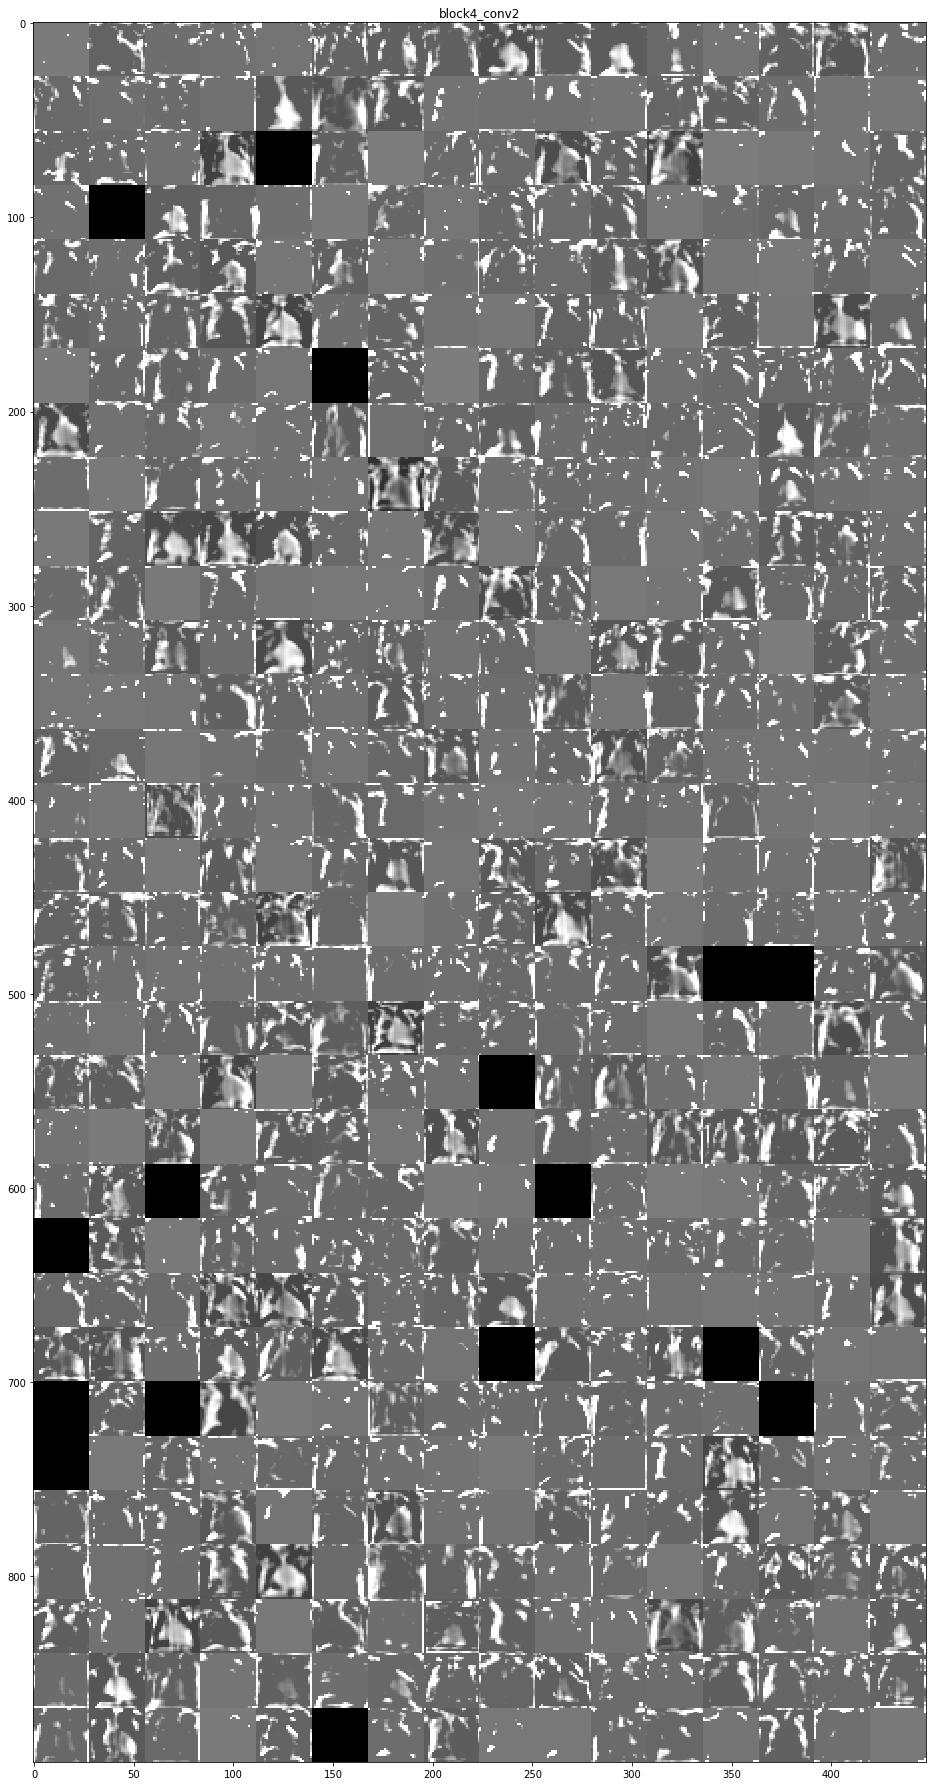

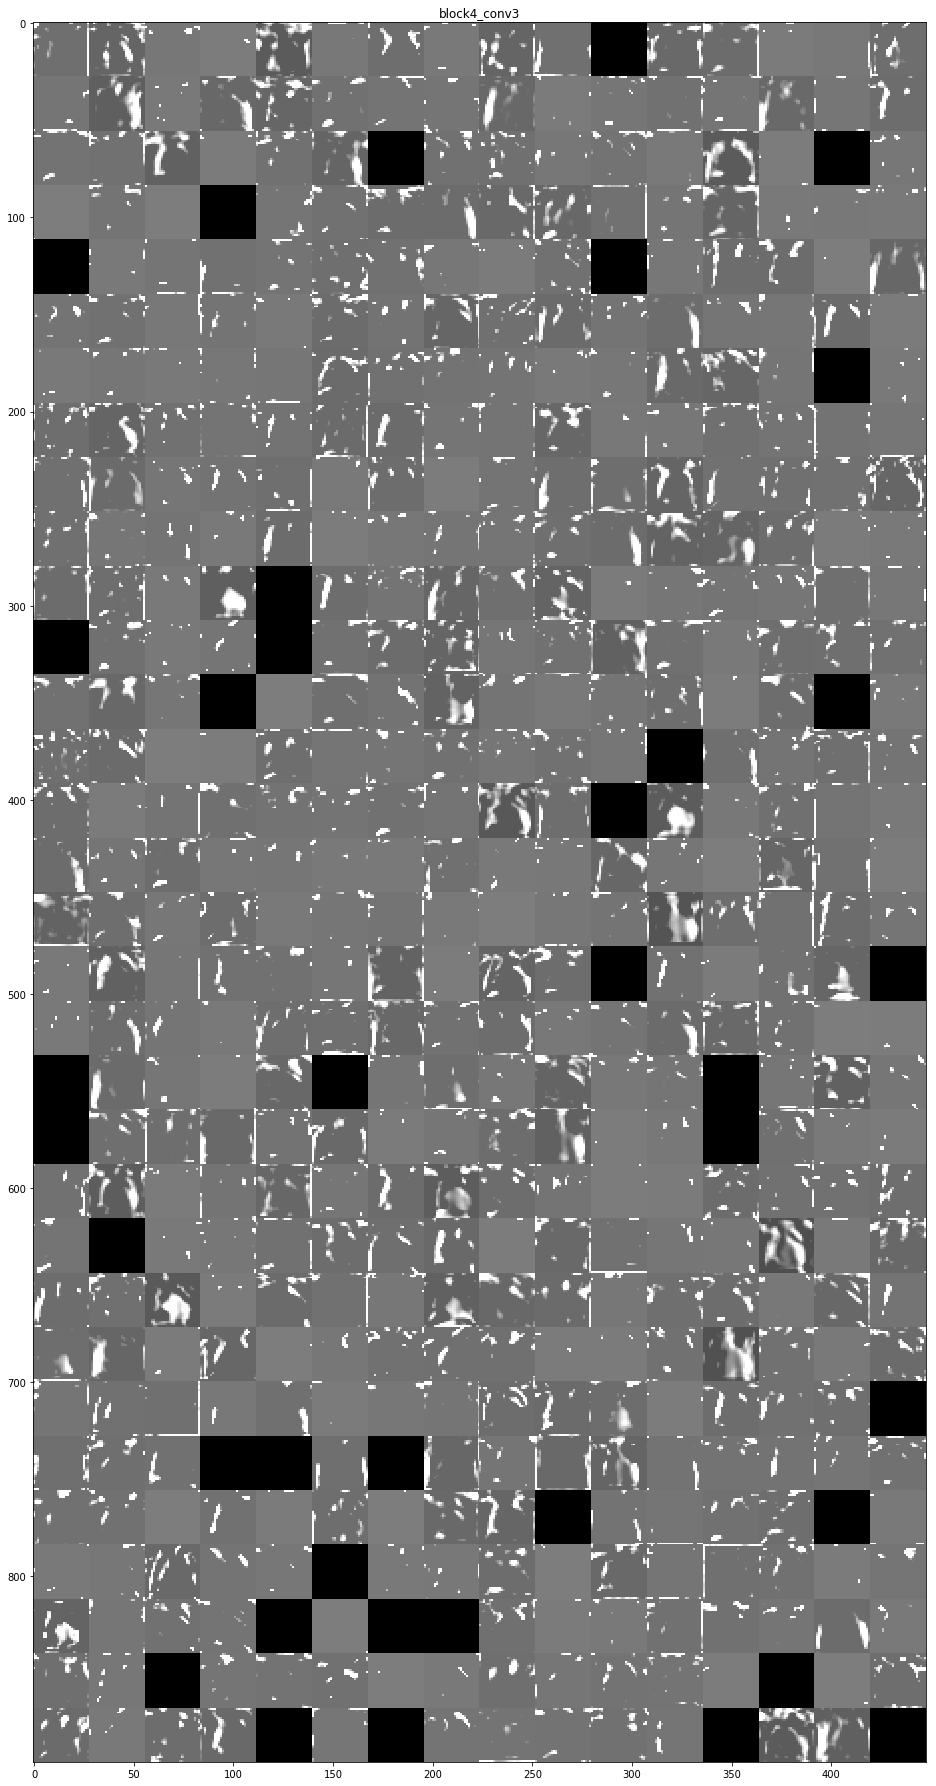

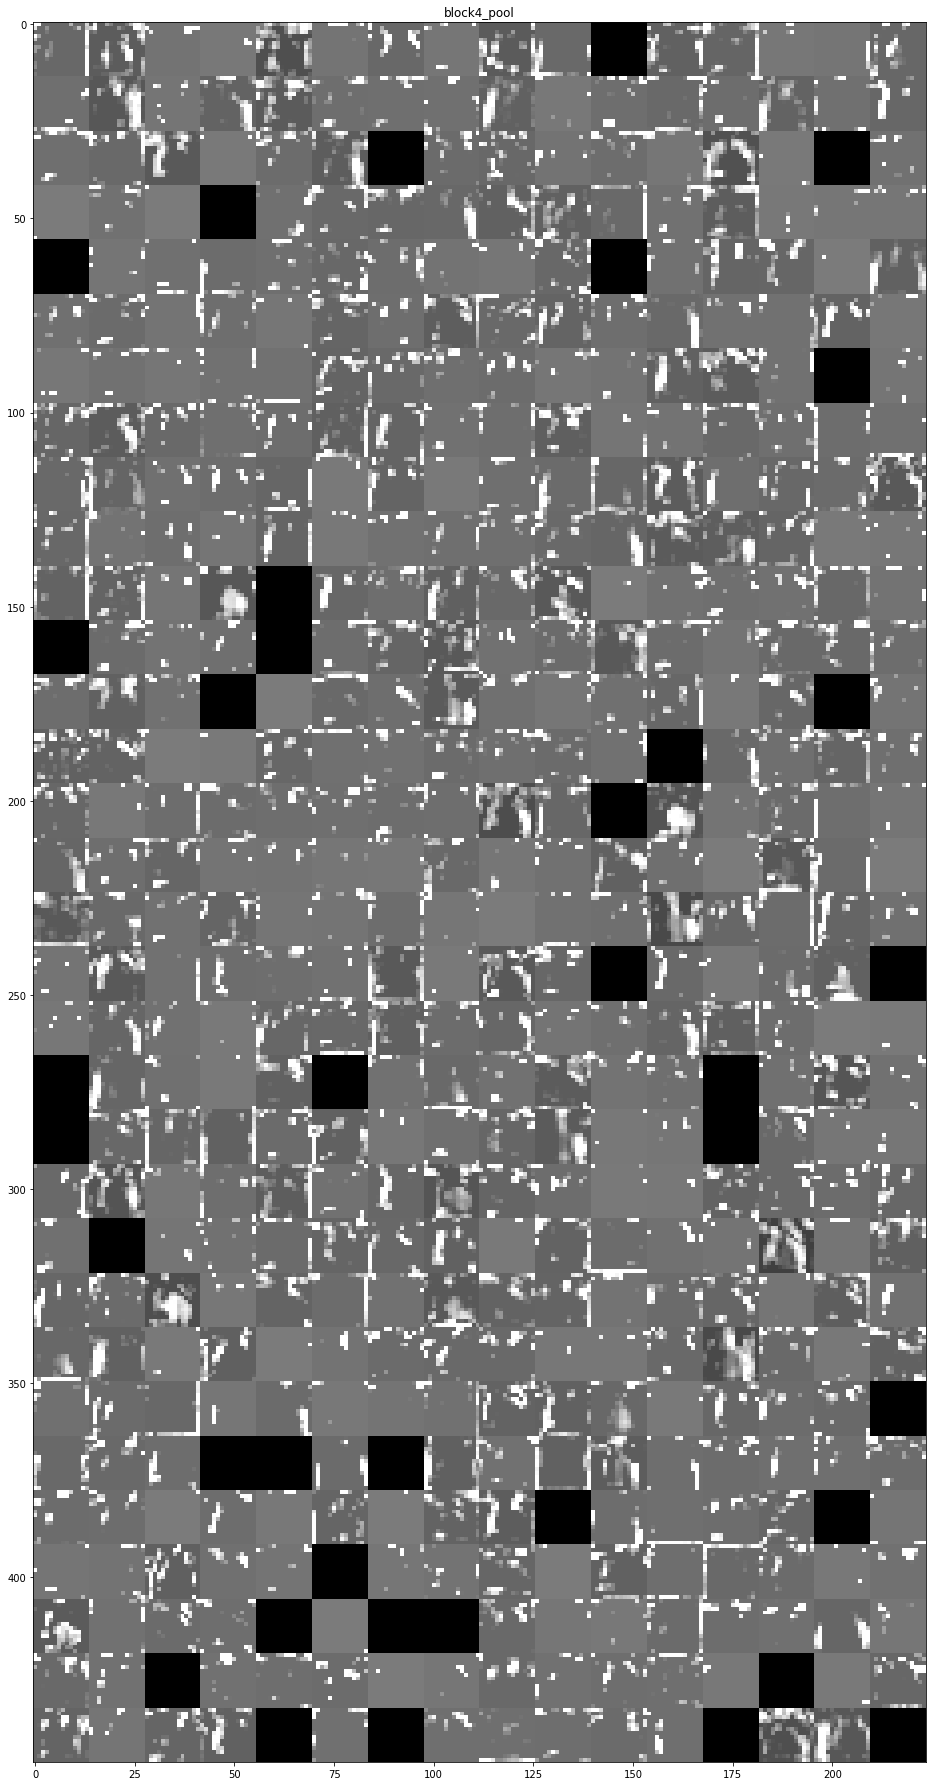

In [36]:
layer_names = []
for layer in model.layers[1:15]:
    layer_names.append(layer.name) 
    
images_per_row = 16

for layer_name, layer_activation in zip(layer_names, activations): # Displays the feature maps
    n_features = layer_activation.shape[-1] # Number of features in the feature map
    size = layer_activation.shape[1] #The feature map has shape (1, size, size, n_features).
    n_cols = n_features // images_per_row # Tiles the activation channels in this matrix
    display_grid = np.zeros((size * n_cols, images_per_row * size))
    for col in range(n_cols): # Tiles each filter into a big horizontal grid
        for row in range(images_per_row):
            channel_image = layer_activation[0,
                                             :, :,
                                             col * images_per_row + row]
            channel_image -= channel_image.mean() # Post-processes the feature to make it visually palatable
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size, # Displays the grid
                         row * size : (row + 1) * size] = channel_image
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='gray')

**Creating the class activation map. Class activation maps tells us which part of the image was most dominant is predicting the output class. Red denotes for high dominating part while blue denotes least involving part**

(7, 7, 512)


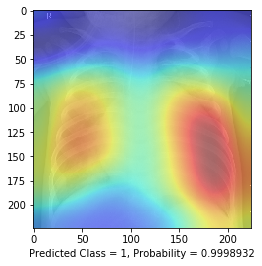

In [37]:
import scipy as sp

# get the weights from the last layer
gap_weights = model.layers[-1].get_weights()[0]

# create a new model to output the feature maps and the predicted labels
cam_model = Model(inputs=model.input, outputs=(model.layers[-4].output, model.layers[-1].output)) 

# make the prediction for a set of test images
features, results = cam_model.predict(img_tensor)

# check the prediction test image
# get the feature map of the test image
features_for_one_img = features[0,:,:,:]

print(features_for_one_img.shape)

# map the feature map to the original size
height_roomout = 224 / features_for_one_img.shape[0]
width_roomout = 224 / features_for_one_img.shape[1]
cam_features = sp.ndimage.zoom(features_for_one_img, (height_roomout, width_roomout, 1), order=3)

# get the predicted label with the maximum probability
pred = np.argmax(results[0])

# prepare the final display
plt.figure(facecolor='white')

# get the weights of class activation map
cam_weights = gap_weights[:, pred]

# create the class activation map
cam_output = np.dot(cam_features, cam_weights)

# draw the class activation map
buf = 'Predicted Class = ' + str(pred) + ', Probability = ' + str(results[0][pred])
plt.xlabel(buf)
plt.imshow(img_tensor[0], alpha=0.5)
plt.imshow(cam_output, cmap='jet', alpha=0.5)

plt.show()